In [ ]:
#https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5

#1.Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

## Download data

In [3]:
# Get data (10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-01-30 17:26:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.66.128, 173.194.68.128, 173.194.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.66.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   166MB/s    in 1.0s    

2023-01-30 17:26:44 (166 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#How many images in each folder
import os

#walk through 10 percent data directory and list number of files
for dirpath,dirnames,filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filename)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## ImageDataGenerator class to load in our images in batches

In [5]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale =1/255.)
test_datagen = ImageDataGenerator(rescale =1/255.)

print("Training Images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode ="categorical")

print("Testing Images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode ="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up Callbacks(things to run whilst our model trains)

In [6]:
#Create TensorBoard callback(functionized because we need to create a new one for eachmodel)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to :{log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [8]:
mobilenet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
#Lets make a create model) function to create a model from a URL
def create_model(model_url,num_classes=10):
  #Download pretrained model and save it as keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable = False,
                                            name = "feature_extraction_layer",
                                            input_shape = IMAGE_SHAPE+(3,))
  
  #Create our model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation ="softmax", name="output_layer")
  ])

  return model

## Creating and testing Efficient Tensorflow hub feature extraction model

In [12]:
#Create Resnet model
efficient_model = create_model(mobilenet_url,
                             num_classes = train_data_10_percent.num_classes)

In [14]:
#Compile our resnet model
efficient_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [15]:
#Fit the model
efficient_history = efficient_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficient")]
                                  )

Saving Tensorboard log files to :tensorflow_hub/efficient/20230130-173658
Epoch 1/5
24/24 [==============================] - 205s 8s/step - loss: 1.8695 - accuracy: 0.4147 - val_loss: 1.3308 - val_accuracy: 0.7256
Epoch 2/5
24/24 [==============================] - 183s 8s/step - loss: 1.0809 - accuracy: 0.7747 - val_loss: 0.8903 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 182s 8s/step - loss: 0.7724 - accuracy: 0.8387 - val_loss: 0.7125 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 183s 8s/step - loss: 0.6191 - accuracy: 0.8640 - val_loss: 0.6243 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 182s 8s/step - loss: 0.5215 - accuracy: 0.8920 - val_loss: 0.5676 - val_accuracy: 0.8624


In [17]:
#Lets create function to plot loss curves
import matplotlib.pyplot as plt

#Plot validation and training curves separately
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="Training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="Training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

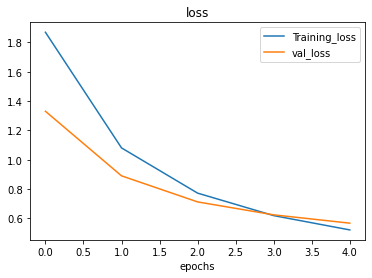

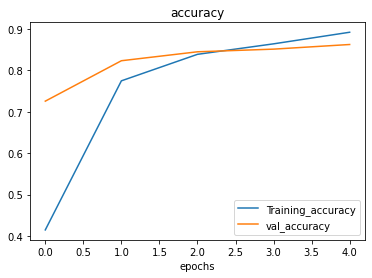

In [18]:
#plot loss curves for resnet model
plot_loss_curves(efficient_history)

#2.Build a model to classify images of two different things you've taken photos of.

## Unzip the file

In [19]:
# Get data (10% of 10 food classes from Food101)
import zipfile


#Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/sample_data/feature_extraction.zip")
zip_ref.extractall()
zip_ref.close()

In [20]:
#How many images in each folder
import os

#walk through 10 percent data directory and list number of files
for dirpath,dirnames,filename in os.walk("feature_extraction"):
  print(f"There are {len(dirnames)} directories and {len(filename)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'feature_extraction'.
There are 2 directories and 1 images in 'feature_extraction/Test'.
There are 0 directories and 5 images in 'feature_extraction/Test/Oven'.
There are 0 directories and 5 images in 'feature_extraction/Test/Fridge'.
There are 2 directories and 1 images in 'feature_extraction/Train'.
There are 0 directories and 17 images in 'feature_extraction/Train/Oven'.
There are 0 directories and 17 images in 'feature_extraction/Train/Fridge'.


In [22]:
! ls /content/feature_extraction/Train/Fridge | wc -l

16


In [23]:
! ls /content/feature_extraction/Train/Oven| wc -l

16


## Preprocess

In [24]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "/content/feature_extraction/Train/"
test_dir = "/content/feature_extraction/Test/"


train_datagen = ImageDataGenerator(rescale =1/255.)
test_datagen = ImageDataGenerator(rescale =1/255.)

print("Training Images:")

train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode ="binary")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode ="binary")

Training Images:
Found 32 images belonging to 2 classes.
Testing Images:
Found 8 images belonging to 2 classes.


## Setting up Callbacks

In [25]:
#Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to :{log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [26]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [27]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [28]:
#Download pretrained model and save it as keras layer
feature_extraction_layer = hub.KerasLayer(efficientnet_url,
                                            trainable = False,
                                            name = "feature_extraction_layer",
                                            input_shape = IMAGE_SHAPE+(3,))

In [41]:
#Create our model
model_fe = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(1, activation ="sigmoid", name="output_layer")
])

In [42]:
#Compile Efficientnet model
model_fe.compile(loss = tf.keras.losses.binary_crossentropy,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [44]:
#Fit the Efficientnet model on training data
feature_ex_history = model_fe.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data),
                                  validation_data = test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name="efficientnetb0_exercise")])

Saving Tensorboard log files to :tensorflow_hub/efficientnetb0_exercise/20230130-185646
Epoch 1/5
1/1 [==============================] - 16s 16s/step - loss: 0.5727 - accuracy: 0.6562 - val_loss: 0.5636 - val_accuracy: 0.6250
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.5261 - accuracy: 0.7188 - val_loss: 0.5249 - val_accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.4831 - accuracy: 0.8125 - val_loss: 0.4889 - val_accuracy: 0.8750
Epoch 4/5
1/1 [==============================] - 4s 4s/step - loss: 0.4439 - accuracy: 0.8750 - val_loss: 0.4555 - val_accuracy: 0.8750
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.4082 - accuracy: 0.8750 - val_loss: 0.4246 - val_accuracy: 0.8750


In [45]:
model_fe.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________
